# Global Happiness Predictions

## Introduction

Happiness depends on many things such as country’s economy, social support, and health. In this project, we look at data from different countries to see what really drives happiness. Using data analysis, machine learning, and clear visualizations, we try to understand patterns and predict how happiness might change in the future.

## Data Preprocessing

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
# Load the dataset
df = pd.read_csv('./dataset/dataset.csv')

# Display the first few rows of the dataset
display(df.head())

,country,region,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,year
0,Finland,Western Europe,7.804,1.888,1.585,0.535,0.772,0.126,0.535,2023
1,Denmark,Western Europe,7.586,1.949,1.548,0.537,0.734,0.208,0.525,2023
2,Iceland,Western Europe,7.530,1.926,1.620,0.559,0.738,0.250,0.187,2023
3,Israel,Middle East and North Africa,7.473,1.833,1.521,0.577,0.569,0.124,0.158,2023
4,Netherlands,Western Europe,7.403,1.942,1.488,0.545,0.672,0.251,0.394,2023


In [3]:
# Get a summary of the dataset
df.info()

# Display basic statistics of the dataset
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       1367 non-null   object 
 1   region                        1367 non-null   object 
 2   happiness_score               1367 non-null   float64
 3   gdp_per_capita                1367 non-null   float64
 4   social_support                1367 non-null   float64
 5   healthy_life_expectancy       1366 non-null   float64
 6   freedom_to_make_life_choices  1367 non-null   float64
 7   generosity                    1367 non-null   float64
 8   perceptions_of_corruption     1366 non-null   float64
 9   year                          1367 non-null   int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 106.9+ KB


,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,year
count,1367.000000,1367.000000,1367.000000,1366.000000,1367.000000,1367.000000,1366.000000,1367.000000
mean,5.441086,1.019422,1.045334,0.584043,0.450771,0.196260,0.132275,2018.903438
std,1.117909,0.453703,0.331163,0.245117,0.156733,0.113301,0.112555,2.561006
min,1.859000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,4.599500,0.696326,0.832022,0.402301,0.356000,0.115000,0.056826,2017.000000
50%,5.440000,1.043000,1.083000,0.612830,0.467610,0.182700,0.097000,2019.000000
75%,6.256300,1.338473,1.299985,0.777614,0.568685,0.252858,0.165945,2021.000000
max,7.842000,2.209000,1.644000,1.141000,0.772000,0.838075,0.587000,2023.000000


In [4]:
# Drop rows with nulls
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1365 entries, 0 to 1366
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       1365 non-null   object 
 1   region                        1365 non-null   object 
 2   happiness_score               1365 non-null   float64
 3   gdp_per_capita                1365 non-null   float64
 4   social_support                1365 non-null   float64
 5   healthy_life_expectancy       1365 non-null   float64
 6   freedom_to_make_life_choices  1365 non-null   float64
 7   generosity                    1365 non-null   float64
 8   perceptions_of_corruption     1365 non-null   float64
 9   year                          1365 non-null   int64  
dtypes: float64(7), int64(1), object(2)
memory usage: 117.3+ KB


### 1.1 Correlation Analysis 

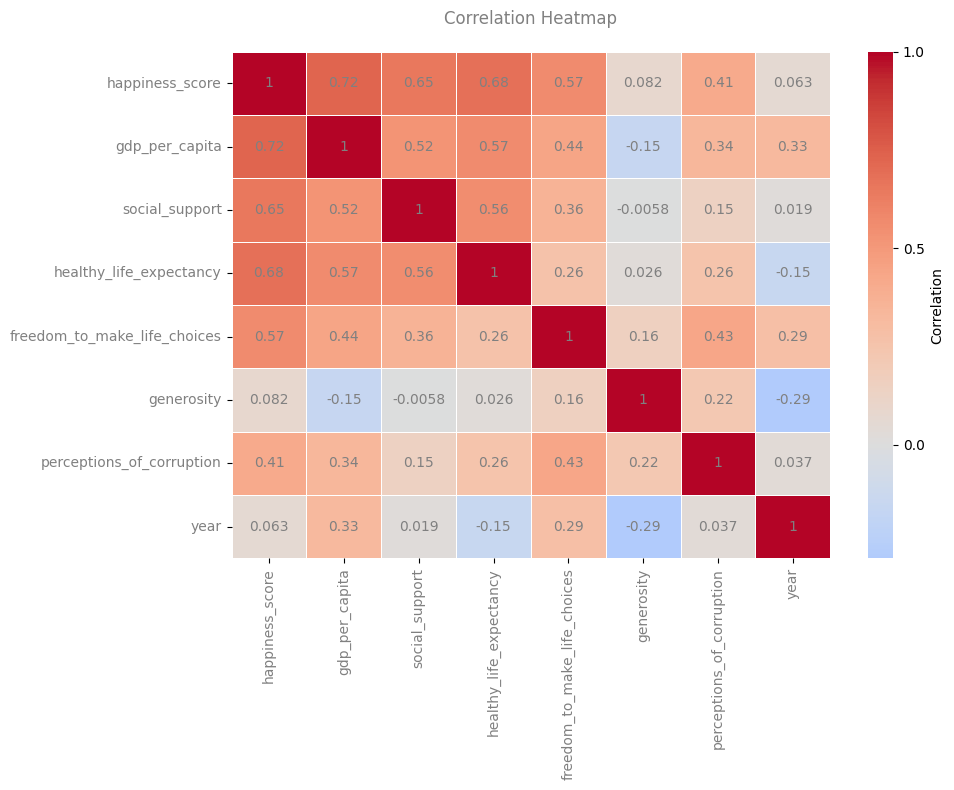

In [5]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = numeric_df.corr()

# Customize the heatmap
plt.figure(figsize=(10, 8))
plt.gca().set_facecolor('#E6E6E6')  # Gray background

sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='w',
    annot_kws={'color': 'gray', 'size': 10},
    cbar_kws={'label': 'Correlation', 'ticks': [-1, -0.5, 0, 0.5, 1]}
)

plt.title('Correlation Heatmap', color='gray', pad=20)
plt.xticks(color='gray')
plt.yticks(color='gray')
plt.tight_layout()
plt.show()

<br><br>

### 1.2 Distributions and Scatterplots 

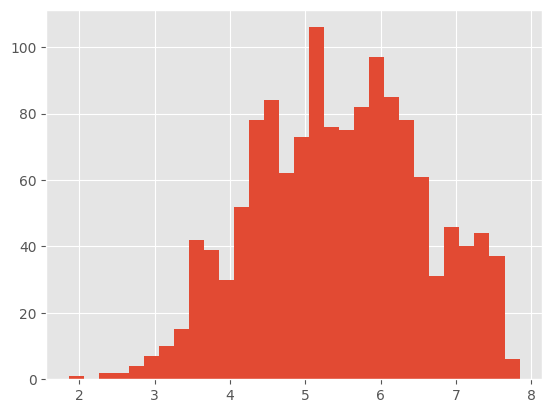

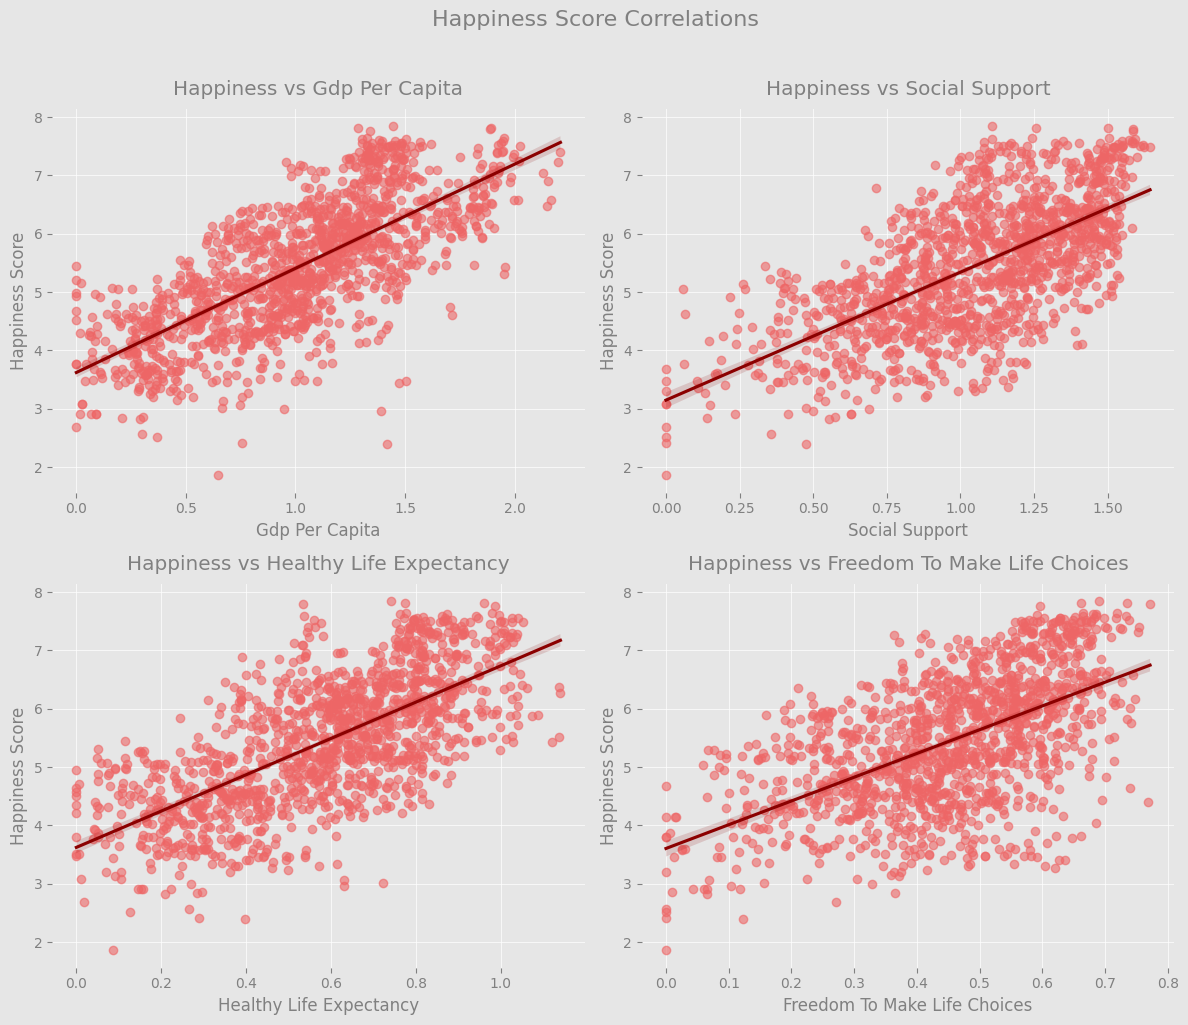

In [6]:
plt.style.use('ggplot')  

df['happiness_score'].hist(bins=30)

# Customize the figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.patch.set_facecolor('#E6E6E6')  # Gray background for the figure
fig.suptitle('Happiness Score Correlations', fontsize=16, y=1.02, color='gray')

# List of features to plot
features = ["gdp_per_capita", "social_support", "healthy_life_expectancy", "freedom_to_make_life_choices"]

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i//2, i%2]
    ax.set_facecolor('#E6E6E6')  # Gray background for each subplot
    
    # Scatterplot with regression line
    sns.regplot(
        x=feature, 
        y="happiness_score", 
        data=df,
        scatter_kws={'alpha': 0.6, 'color': '#EE6666'},  # Reddish scatter points
        line_kws={'color': 'darkred'},  # Darker red regression line
        ax=ax
    )
    
    # Customize titles and labels
    ax.set_title(f"Happiness vs {feature.replace('_', ' ').title()}", color='gray', pad=10)
    ax.set_xlabel(feature.replace('_', ' ').title(), color='gray')
    ax.set_ylabel('Happiness Score', color='gray')
    
    # Customize grid and spines
    ax.grid(color='w', linestyle='solid', alpha=0.7)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Customize ticks
    ax.tick_params(colors='gray', direction='out')
    for tick in ax.get_xticklabels():
        tick.set_color('gray')
    for tick in ax.get_yticklabels():
        tick.set_color('gray')

plt.tight_layout()
plt.show()

1. Distribution (Histogram)
    - Most countries cluster between 4 and 7 happiness score.
    - Very few extremely low (<3) or extremely high (>7.5) scores.

2. Correlation Heatmap
    - Strongest drivers:
        - GDP per capita (0.72)
        - Healthy life expectancy (0.68)
        - Social support (0.65)
    - Medium driver:
        - Freedom to make life choices (0.57)
    - Weak drivers:
        - Perceptions of corruption (0.42)
        - Generosity (0.08, almost no correlation)
    - Year has weak correlation (0.06), meaning happiness didn’t strongly trend up/down globally overall.

3. Scatterplots with Regression Lines
    - GDP, Social Support, Life Expectancy, Freedom → clear positive slopes.
    - Generosity & corruption (not shown here) → weaker/noisy trends.

<br><br>

### 1.3 Time Trends


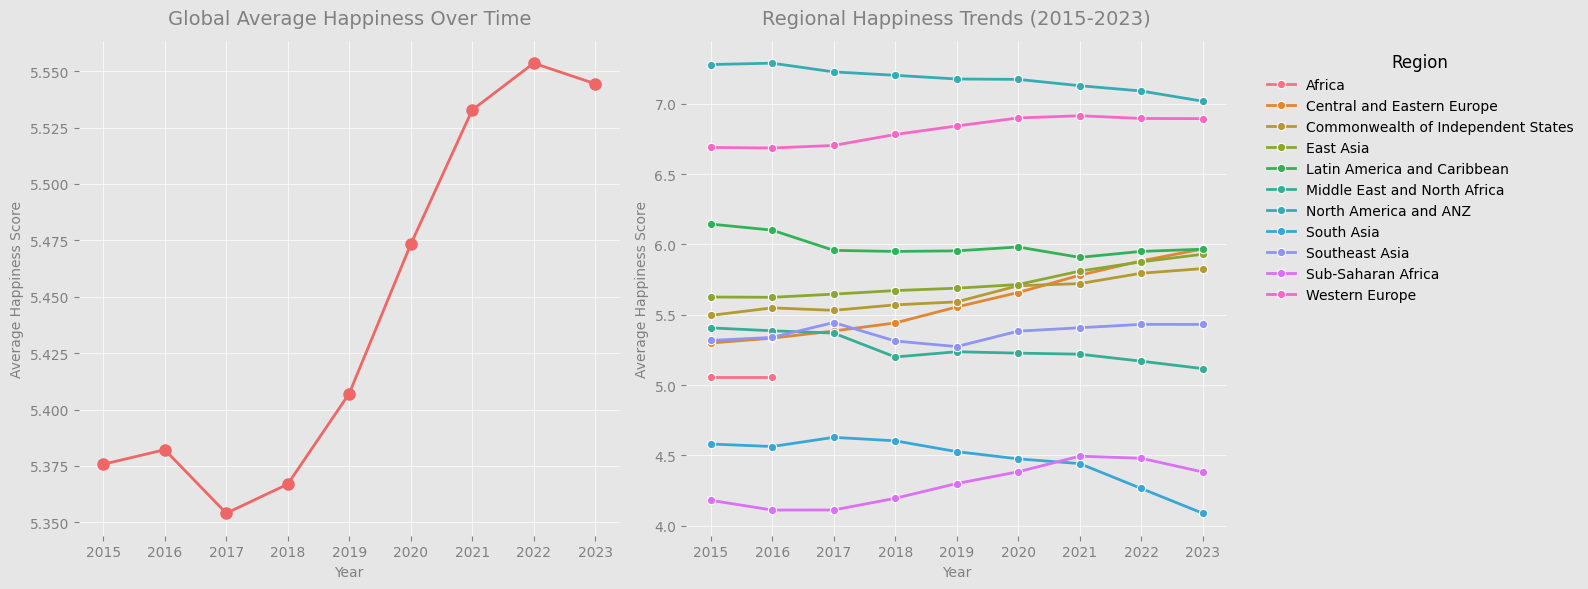

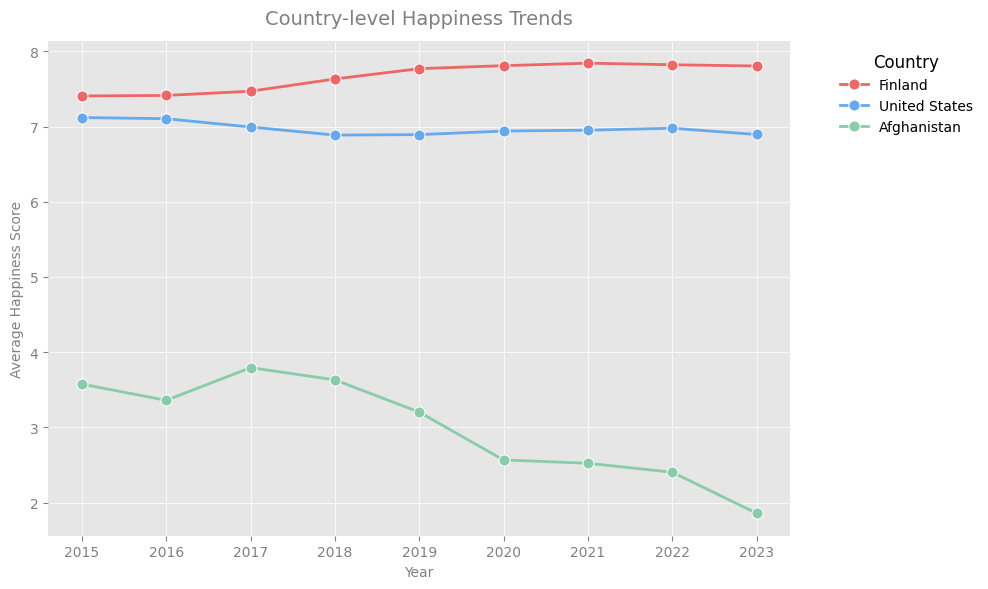

In [7]:
# Style
plt.style.use('default')  
plt.rcParams['axes.facecolor'] = '#E6E6E6' 

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('#E6E6E6')  # Figure background

# Plot 1: Global Trend
global_trend = df.groupby('year')['happiness_score'].mean()
global_trend.plot(
    marker='o',
    color='#EE6666',  # Reddish line for consistency
    linewidth=2,
    markersize=8,
    ax=ax1
)

# Customize Plot 1
ax1.set_title('Global Average Happiness Over Time', color='gray', pad=12, fontsize=14)
ax1.set_xlabel('Year', color='gray')
ax1.set_ylabel('Average Happiness Score', color='gray')
ax1.grid(color='w', linestyle='solid', alpha=0.7)
ax1.tick_params(colors='gray', direction='out')
for spine in ax1.spines.values():
    spine.set_visible(False)

# Plot 2: Regional Trends 
region_trends = df.groupby(['year', 'region'])['happiness_score'].mean().reset_index()
sns.lineplot(
    x="year",
    y="happiness_score",
    hue="region",
    data=region_trends,
    marker="o",
    palette='husl',  # Distinct colors for regions
    linewidth=2,
    markersize=6,
    ax=ax2
)

# Customize Plot 2
ax2.set_title('Regional Happiness Trends (2015-2023)', color='gray', pad=12, fontsize=14)
ax2.set_xlabel('Year', color='gray')
ax2.set_ylabel('Average Happiness Score', color='gray')
ax2.grid(color='w', linestyle='solid', alpha=0.7)
ax2.tick_params(colors='gray', direction='out')
for spine in ax2.spines.values():
    spine.set_visible(False)

# Move legend outside for clarity
ax2.legend(
    title="Region",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
    title_fontsize=12,
    fontsize=10
)

# Adjust layout
plt.tight_layout()
plt.show()

# Plot 3: Country Trends  
plt.figure(figsize=(10, 6))
country_trends = df[df['country'].isin(["Finland", "United States", "Afghanistan"])]
sns.lineplot(
    x="year",
    y="happiness_score",
    hue="country",
    data=country_trends,
    marker='o',
    palette=['#EE6666', '#66AAEE', '#88CCAA'],  # Custom colors
    linewidth=2,
    markersize=8
)

# Customize Plot 3
plt.gca().set_facecolor('#E6E6E6')
plt.title('Country-level Happiness Trends', color='gray', pad=12, fontsize=14)
plt.xlabel('Year', color='gray')
plt.ylabel('Average Happiness Score', color='gray')
plt.grid(color='w', linestyle='solid', alpha=0.7)
plt.gca().tick_params(colors='gray', direction='out')
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Move legend outside
plt.legend(
    title="Country",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
    title_fontsize=12,
    fontsize=10
)

plt.tight_layout()
plt.show()

                                        

1. Global Average (2015–2023)
    - Pretty stable overall: ~5.35 → ~5.55.
    - Small dip in 2017, strong recovery after 2019, peaking in 2022.

2. Regional Trends (from before, once legend fixed)
    - Western Europe & North America/ANZ consistently top.
    - Sub-Saharan Africa & South Asia consistently lowest.
    - Some mid-tier regions (Latin America, Eastern Europe) show mild fluctuations.

3. Country Trends
    - Finland steadily rising → consistently #1 since ~2018.
    - United States flat/slight decline → hovering ~7.0.
    - Afghanistan sharp decline post-2017 → now the lowest globally.

<br><br>

### 1.4 Ranking

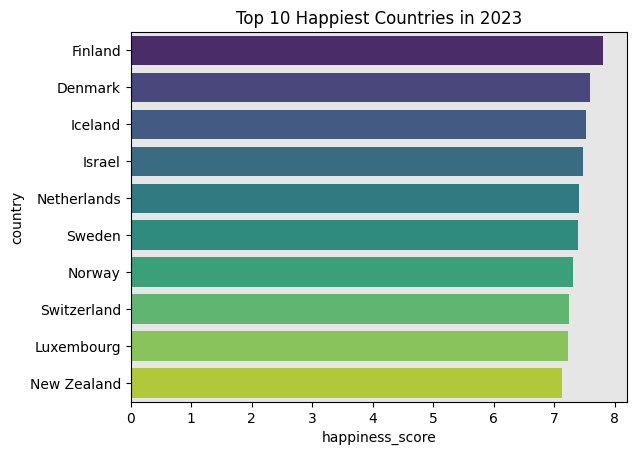

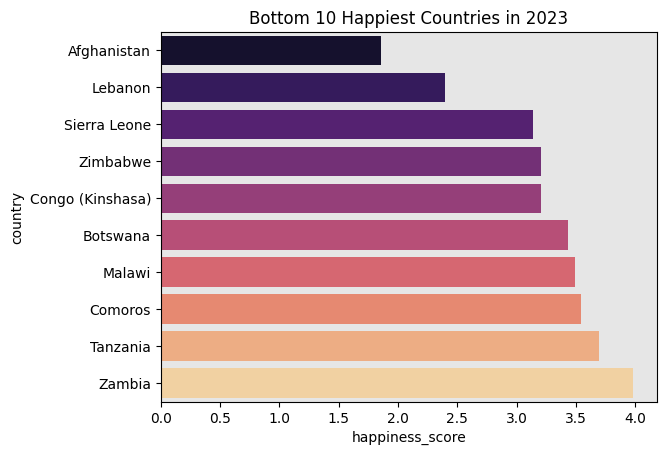

In [8]:
# Top 10 happiest countries lastest year
latest_year = df['year'].max()
top10 =df[df['year']==latest_year].nlargest(10, 'happiness_score')

sns.barplot(x="happiness_score", y="country", data=top10, hue="country", dodge=False, legend=False, palette="viridis")
plt.title(f"Top 10 Happiest Countries in {latest_year}")
plt.show()

# Bottom 10 happiest countries lastest year
bottom10 =df[df['year']==latest_year].nsmallest(10, 'happiness_score')

sns.barplot(x="happiness_score", y="country", data=bottom10, hue="country", dodge=False, legend=False, palette="magma")
plt.title(f"Bottom 10 Happiest Countries in {latest_year}")
plt.show()



### Top 10 Happiess Countries for 2023:
- Finland is clearly the topest(score ~7.5)
- Denmark and Iceland are following it (score ~7.3 and ~7.4)

### Bottom 10 Happiess Countries for 2023:
- Afghanistan is clearly the lowest (score ~1.9).
- Several Sub-Saharan African countries dominate the bottom of the list.
- Lebanon also shows up very low, reflecting its recent crises.<br><br>

<br><br>

## Exploratory Data Analysis (EDA) Summary

### 1. Distribution of Happiness Scores
- Happiness scores (2015–2023) range between **~2 and ~8**.
- The majority of countries fall between **4 and 7**.
- Very few countries achieve extremely low or extremely high scores.


### 2. Correlation Insights
- **GDP per capita (0.72)**, **social support (0.65)**, and **healthy life expectancy (0.68)** show the strongest positive correlation with happiness.
- **Freedom to make life choices (0.57)** also has a significant positive correlation.
- **Generosity (0.08)** has a weak correlation with happiness.
- **Perceptions of corruption (0.41)** shows moderate correlation.
- Year itself has very low correlation, meaning global scores are fairly stable.



### 3. Key Relationships
- **Happiness increases** with higher GDP, stronger social support, longer healthy life expectancy, and greater freedom of choice.
- Scatter plots confirm clear **positive linear trends** for these key features.



### 4. Regional Analysis
- **Western Europe, North America, and ANZ** report the **highest average happiness**.
- **Sub-Saharan Africa and South Asia** consistently have **lower scores**.
- Regional happiness is relatively stable over time, with **Western Europe leading**.


### 5. Country-Level Trends
- **Finland** remains the happiest country with consistently high scores since 2015.
- **United States** shows stable but slightly lower scores (~6.8–7.1).
- **Afghanistan** ranks the lowest, with a sharp decline after 2018.



### 6. Top & Bottom Countries in 2023
- **Top 10 Happiest Countries:** Finland, Denmark, Iceland, Israel, Netherlands, Sweden, Norway, Switzerland, Luxembourg, New Zealand.
- **Bottom 10 Happiest Countries:** Afghanistan, Lebanon, Sierra Leone, Zimbabwe, Congo (Kinshasa), Botswana, Malawi, Comoros, Tanzania, Zambia.



### 7. Global Happiness Trend
- Global average happiness is **stable around 5.3–5.5**.
- A slight increase is visible after 2018, peaking around 2022.



### Key Takeaways
- Economic prosperity (**GDP per capita**) and social well-being (**support, health, freedom**) are the most critical drivers of happiness.
- Regions differ significantly, highlighting inequalities.
- Despite yearly variations, **global happiness levels remain stable**.


## Model Training

#### Split dataset into train years and test year

In [9]:
# Train = 2015–2022, Test = 2023
train = df['year'] < 2023
test = df['year'] == 2023

X_train = df[train].drop(columns=['country', 'region', 'year', 'happiness_score'])
y_train = df[train]['happiness_score']

X_test = df[test].drop(columns=['country', 'region', 'year', 'happiness_score'])
y_test = df[test]['happiness_score']

#### Define TimeSeriesSplit (for cv)

In [10]:
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) 

### Dummy Baseline

In [11]:
# Create and train a Dummy Regressor model
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

# Predict using the Dummy Regressor model
y_pred_dummy = dummy.predict(X_test)

# Evaluate Dummy Regressor model
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
rmse_dummy = np.sqrt(mse_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

# Display Dummy Regressor evaluation metrics
print("\nDummy Regressor Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_dummy:.2f}")
print(f"Mean Squared Error (MSE): {mse_dummy:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_dummy:.2f}")
print(f"R-squared (R²): {r2_dummy:.2f}")


Dummy Regressor Model Evaluation:
Mean Absolute Error (MAE): 0.94
Mean Squared Error (MSE): 1.31
Root Mean Squared Error (RMSE): 1.14
R-squared (R²): -0.01


### Sanity Check - Linear Regression

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluate Linear Regression model
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

# Display Linear Regression evaluation metrics
print("Linear Regression Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.2f}")
r2_lr = r2_score(y_test, y_pred_lr)

print(f"R-squared (R²): {r2_lr:.2f}")

Linear Regression Model Evaluation:
Mean Absolute Error (MAE): 0.39
Mean Squared Error (MSE): 0.30
Root Mean Squared Error (RMSE): 0.55
R-squared (R²): 0.77


### Scaling

In [13]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

### Ridge Regression

In [14]:
# Initialize Ridge Regression
ridge = Ridge(random_state=7)

# Define Ridge parameter grid
param_grid_ridge = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg']
}

# GridSearchCV setup
grid_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid_ridge,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

# Fit to training data
grid_ridge.fit(X_train_scaled, y_train)

# Best estimator from GridSearchCV
best_ridge = grid_ridge.best_estimator_

# Best parameters from GridSearchCV
print("Best Hyperparameters:", grid_ridge.best_params_)

# Predict using the best Ridge Regression model
y_pred_ridge = best_ridge.predict(X_test_scaled)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Display Ridge Regression evaluation metrics after hyperparameter tuning
print("\nTuned Ridge Regression Model Evaluation:")
print("Best Cross-Validation R²:", grid_ridge.best_score_)
print(f"Mean Absolute Error (MAE): {mae_ridge:.2f}")
print(f"Mean Squared Error (MSE): {mse_ridge:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge:.2f}")
print(f"R-squared (R²): {r2_ridge:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'alpha': 100.0, 'solver': 'svd'}

Tuned Ridge Regression Model Evaluation:
Best Cross-Validation R²: 0.7059768974462424
Mean Absolute Error (MAE): 0.38
Mean Squared Error (MSE): 0.30
Root Mean Squared Error (RMSE): 0.54
R-squared (R²): 0.77
